In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import datetime
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import gc

In [2]:
train = pd.read_csv('train.csv')
test1 = pd.read_csv('test1.csv')
# labels = train['label']
df_train = train.drop(['Unnamed: 0'], axis=1)
df_test = test1.drop(['Unnamed: 0'], axis=1)

FileNotFoundError: [Errno 2] File train.csv does not exist: 'train.csv'

### 数据类型转换

In [3]:
for col in ["android_id","apptype","carrier","ntt","media_id","cus_type","package",'fea1_hash',"location"]:
    df_train[col]=df_train[col].astype("object")
    df_test[col]=df_test[col].astype("object")

for col in ["fea_hash"]:
    df_train[col]=df_train[col].map(lambda x:0 if len(str(x))>16 else int(x))
    df_test[col]=df_test[col].map(lambda x:0 if len(str(x))>16 else int(x))

# df_train["timestamp"]=pd.to_datetime(df_train['timestamp'],unit='ms',origin=pd.Timestamp('1970-01-01'))
# df_test["timestamp"]=pd.to_datetime(df_test['timestamp'],unit='ms',origin=pd.Timestamp('1970-01-01'))

df_train.set_index("sid",drop=True,inplace=True)
df_test.set_index("sid",drop=True,inplace=True)

NameError: name 'df_train' is not defined

In [4]:
df_train.dtypes

android_id     object
apptype        object
carrier        object
dev_height    float64
dev_ppi       float64
dev_width     float64
label           int64
lan            object
media_id       object
ntt            object
os             object
osv            object
package        object
timestamp     float64
version        object
fea_hash        int64
location       object
fea1_hash      object
cus_type       object
dtype: object

## EDA

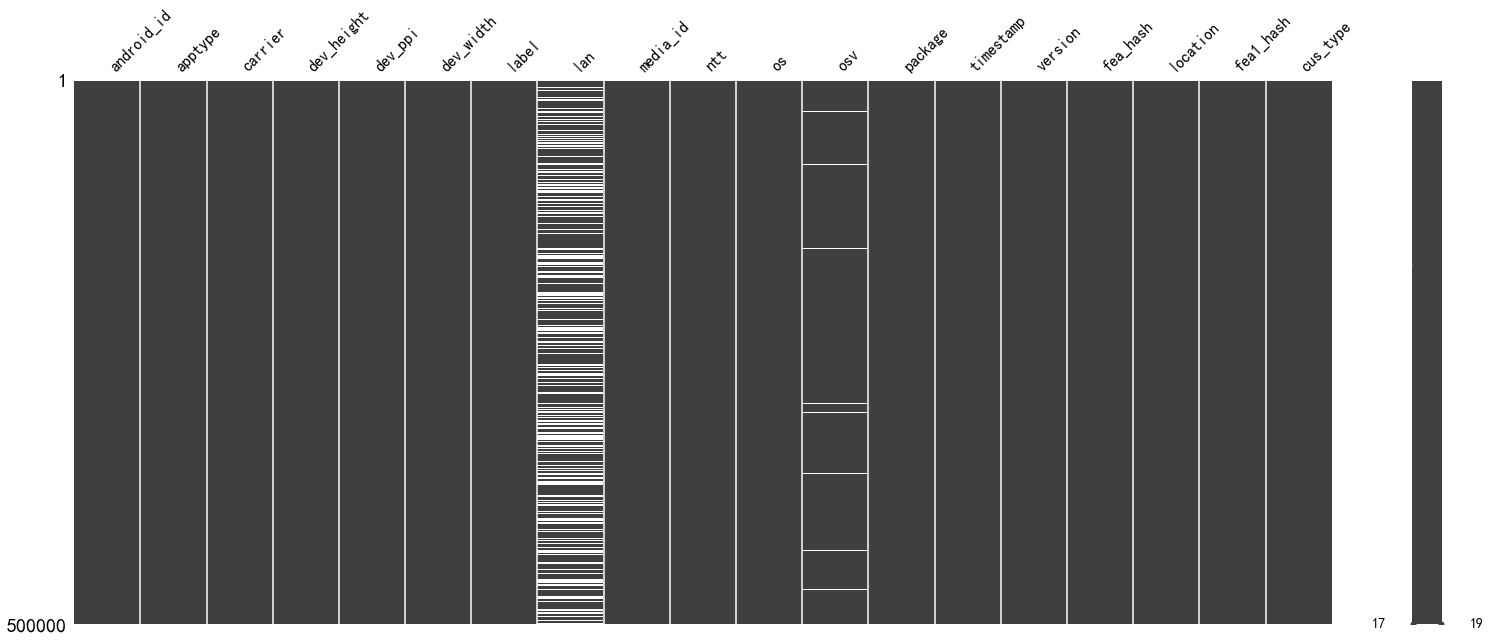

In [130]:
msno.matrix(df_train)

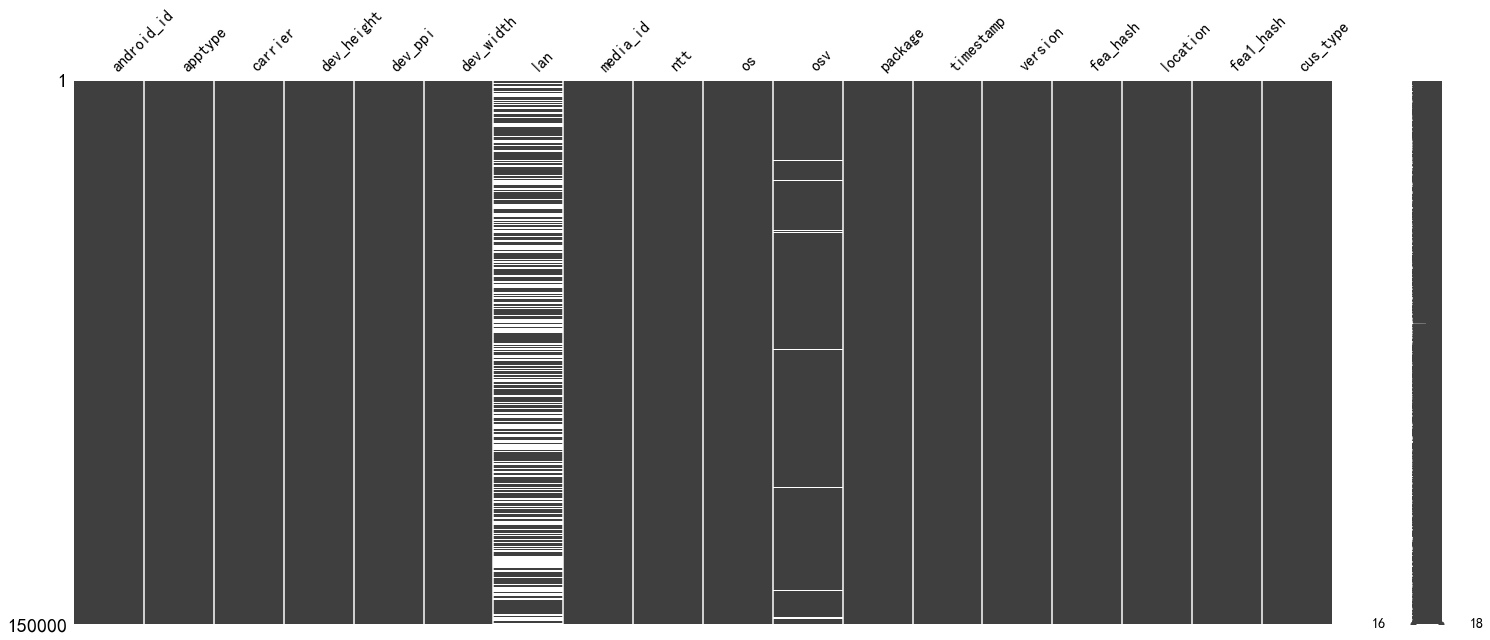

In [131]:
msno.matrix(df_test)

In [132]:
def summary_stats_table(data):
    '''
    祖传代码：分类型按列的数据分布与异常值统计
    '''
    # 空值数量
    missing_counts = pd.DataFrame(data.isnull().sum())
    missing_counts.columns = ['count_null']

    # 数值列数据分布统计
    num_stats = data.select_dtypes(include=['int64','float64']).describe().loc[['count','min','max','25%','50%','75%']].transpose()
    num_stats['dtype'] = data.select_dtypes(include=['int64','float64']).dtypes.tolist()

    # 非数值列数据分布统计
    non_num_stats = data.select_dtypes(exclude=['int64','float64']).describe().transpose()
    non_num_stats['dtype'] = data.select_dtypes(exclude=['int64','float64']).dtypes.tolist()
    non_num_stats = non_num_stats.rename(columns={"first": "min", "last": "max"})

    # 聚合结果
    stats_merge = pd.concat([num_stats, non_num_stats], axis=0, join='outer', ignore_index=False, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True, sort=False).fillna("").sort_values('dtype')

    column_order = ['dtype', 'count', 'count_null','unique','min','max','25%','50%','75%','top','freq']
    summary_stats = pd.merge(stats_merge, missing_counts, left_index=True, right_index=True, sort=False)[column_order]
    return(summary_stats)
summary_stats_table(df_train)

dtype     count  count_null  unique          min          max  \
label         int64  500000.0           0                    0            1   
fea_hash      int64  500000.0           0                    0  4.29494e+09   
dev_height  float64  500000.0           0                    0         9024   
dev_ppi     float64  500000.0           0                    0          720   
dev_width   float64  500000.0           0                    0         8832   
timestamp   float64  500000.0           0          1.55949e+12   1.5601e+12   
location     object  500000.0           0     332                             
version      object  500000.0           0      22                             
package      object  500000.0           0    1950                             
osv          object  493439.0        6561     154                             
os           object  500000.0           0       2                             
lan          object  316720.0      183280      21                             
media_id     object  500000.0           0     284                             
fea1_hash    object  500000.0           0    4959                             
carrier      object  500000.0           0       5                             
apptype      object  500000.0           0      89                             
android_id   object  500000.0           0  362258                             
ntt          object  500000.0           0       8                             
cus_type     object  500000.0           0      58                             

                    25%          50%          75%         top    freq  
label                 0            0            1                      
fea_hash    1.03451e+09  2.08719e+09  3.17491e+09                      
dev_height          720         1280         2040                      
dev_ppi               0            0            0                      
dev_width           360          720         1080                      
timestamp   1.55966e+12  1.55982e+12  1.55996e+12                      
location                                                   48   14932  
version                                                     0  292156  
package                                                     0  131906  
osv                                                     8.1.0  151419  
os                                                    android  303175  
lan                                                     zh-CN  244474  
media_id                                                   29   93978  
fea1_hash                                          4190764663   28393  
carrier                                                 46000  359409  
apptype                                                  1001  101248  
android_id                                                  0  126686  
ntt                                                         2  318597  
cus_type                                                  411  133055

In [133]:
summary_stats_table(df_test)

dtype     count  count_null  unique          min          max  \
fea_hash      int64  150000.0           0                    0  4.29492e+09   
dev_height  float64  150000.0           0                    0         8512   
dev_ppi     float64  150000.0           0                    0          640   
dev_width   float64  150000.0           0                    0         9024   
timestamp   float64  150000.0           0          1.55949e+12   1.5601e+12   
location     object  150000.0           0     332                             
version      object  150000.0           0      23                             
package      object  150000.0           0    1293                             
osv          object  148008.0        1992     130                             
os           object  150000.0           0       2                             
lan          object   94453.0       55547      20                             
media_id     object  150000.0           0     248                             
fea1_hash    object  150000.0           0    2159                             
carrier      object  150000.0           0       5                             
apptype      object  150000.0           0      78                             
android_id   object  150000.0           0  110483                             
ntt          object  150000.0           0       7                             
cus_type     object  150000.0           0      58                             

                    25%          50%          75%         top    freq  
fea_hash    1.02766e+09  2.08538e+09  3.18382e+09                      
dev_height          720         1280         2038                      
dev_ppi               0            0            0                      
dev_width           360          720         1080                      
timestamp   1.55966e+12  1.55982e+12  1.55996e+12                      
location                                                   48    4496  
version                                                     0   88113  
package                                                     0   39184  
osv                                                     8.1.0   45224  
os                                                    android   91117  
lan                                                     zh-CN   73046  
media_id                                                   29   28188  
fea1_hash                                          4190764663    8726  
carrier                                                 46000  107691  
apptype                                                  1001   30377  
android_id                                                  0   38242  
ntt                                                         2   95538  
cus_type                                                  411   40239

In [9]:
df_train["timestamp"]=pd.to_datetime(df_train['timestamp'],unit='ms',origin=pd.Timestamp('1970-01-01'))

In [90]:
df_train.sort_values(by=["android_id","timestamp"]).head(5)

android_id apptype carrier  dev_height  dev_ppi  dev_width  label  \
sid                                                                         
1906968          0    1001   46000       780.0      0.0      360.0      1   
1902136          0    1106   46000         0.0      0.0        0.0      0   
1954267          0    1001   46000       760.0      0.0      360.0      1   
1918927          0    1001   46000       760.0      0.0      360.0      1   
1982963          0    1001   46000       780.0      0.0      360.0      1   

           lan media_id ntt       os    osv  package  \
sid                                                    
1906968  zh-CN       29   5  Android  9.0.0        4   
1902136    NaN       39   2  android  6.0.1      644   
1954267  zh-CN       29   2  Android  8.1.0        4   
1918927  zh-CN       29   2  Android  8.1.0        4   
1982963  zh-CN       29   5  Android  9.0.0        4   

                            timestamp version    fea_hash  location  \
sid                                                                   
1906968 2019-06-02 16:00:15.895585938       0  4282615925        54   
1902136 2019-06-02 16:00:21.312201660       0  3090656373         0   
1954267 2019-06-02 16:00:24.751670898       0  1069571953       278   
1918927 2019-06-02 16:00:27.604695068       0  1926710495       266   
1982963 2019-06-02 16:00:35.170181885       0  1431996533       148   

          fea1_hash cus_type  
sid                           
1906968  2661244967      411  
1902136  4226743927      411  
1954267  2594136103      411  
1918927  2594136103      411  
1982963  2594136103      411

In [88]:
df_test.sort_values(by=["android_id","timestamp"]).head(5)

android_id apptype carrier  dev_height  dev_ppi  dev_width    lan  \
sid                                                                         
1956164          0    1001   46000       851.0      0.0      393.0  zh-CN   
1948758          0    1001   46000       760.0      0.0      360.0  zh-CN   
1910707          0    1001   46000       640.0      0.0      360.0  zh-CN   
1947720          0    1001   46000       748.0      0.0      360.0  zh-CN   
1937260          0    1001   46000       760.0      0.0      360.0  zh-CN   

        media_id ntt       os    osv  package     timestamp version  \
sid                                                                   
1956164       29   2  Android  9.0.0        4  1.559491e+12       0   
1948758       29   5  Android  8.1.0        4  1.559491e+12       0   
1910707       29   2  Android  6.0.1        4  1.559491e+12       0   
1947720       29   2  Android  9.0.0        4  1.559492e+12       0   
1937260       29   2  Android  8.1.0        4  1.559492e+12       0   

           fea_hash  location   fea1_hash cus_type  
sid                                                 
1956164  2708042510        53  2694799399      411  
1948758  3385902556        16  2694799399      411  
1910707  2597682799       206  2728353831      411  
1947720  2552620471        21  2694799399      411  
1937260  1367964271       118  2678022183      411

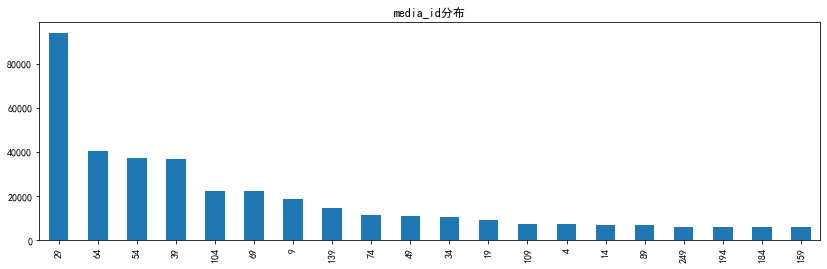

In [12]:
plt.figure(figsize=(14,4))
plt.title('media_id分布')
df_train["media_id"].value_counts().head(20).plot(kind="bar");

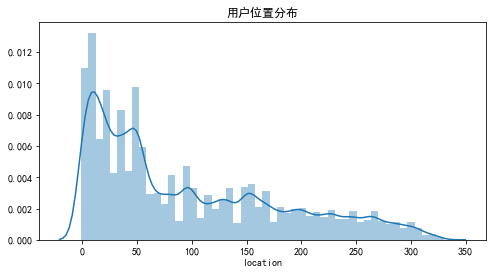

In [14]:
plt.figure(figsize=(8,4))
plt.title('用户位置分布')
sns.distplot(df_train.location)
plt.show()

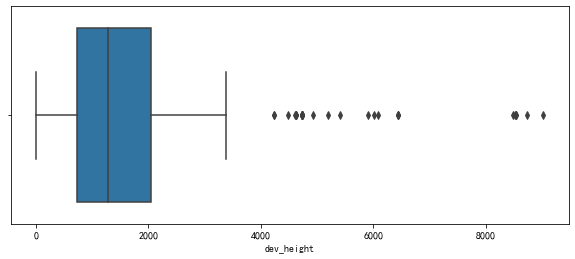

In [36]:
plt.figure(figsize=(10,4))
# x轴坐标范围
# plt.xlim(df_train.dev_height.min(), df_train.dev_height.max()*1.1)
sns.boxplot(x=df_train.dev_height)
plt.show()

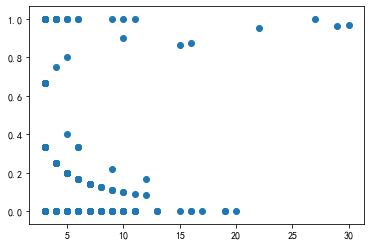

In [72]:
temp=df_train.groupby("android_id").agg({"timestamp":"count","label":"mean"})
plt.scatter(x=temp[(temp.timestamp>2)&(temp.timestamp<50)].timestamp,y=temp[(temp.timestamp>2)&(temp.timestamp<50)].label);

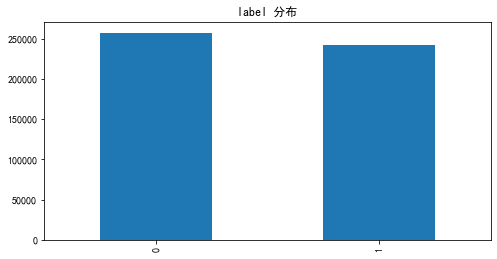

In [121]:
plt.figure(figsize=(8,4))
plt.title('label 分布')
df_train.label.value_counts().plot(kind="bar")
plt.show()

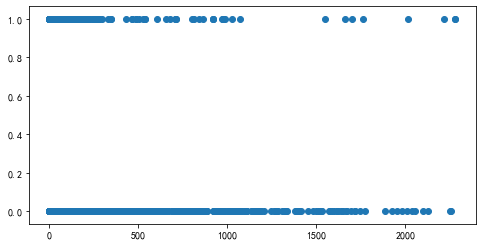

In [37]:
plt.figure(figsize=(8,4))
plt.scatter(x=df_train.package[:20000],y=df_train.label[:20000])

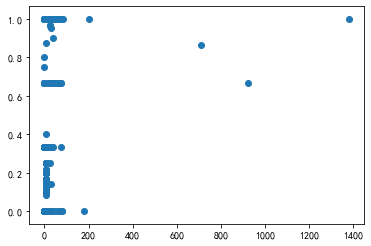

In [87]:
temp=df_train.groupby("android_id").agg({"timestamp":"count","package":"mean","label":"mean"})
plt.scatter(x=temp[(temp.timestamp>2)&(temp.timestamp<50)].package,y=temp[(temp.timestamp>2)&(temp.timestamp<50)].label);

In [80]:
a=df_test.groupby("android_id").agg({"timestamp":"count","package":"mean"})

In [105]:
import scipy.stats as stats
#输出结果第一个值为pearsonr相关系数，
#第二个为p-value，所以这里Guba列和Value值是显著相关的
stats.spearmanr(df_train['dev_ppi'],df_train['label'])
stats.pearsonr(df_train['dev_ppi'],df_train['label'])

SpearmanrResult(correlation=0.0034988302578621753, pvalue=0.013359175108890774)

In [101]:
df_train.corr(method="pearson")

dev_height   dev_ppi  dev_width     label   package  timestamp  \
dev_height    1.000000  0.308117   0.826819  0.090912 -0.190179  -0.021811   
dev_ppi       0.308117  1.000000   0.282013  0.015442 -0.015594  -0.009255   
dev_width     0.826819  0.282013   1.000000  0.055805 -0.170882  -0.016211   
label         0.090912  0.015442   0.055805  1.000000 -0.143005  -0.011059   
package      -0.190179 -0.015594  -0.170882 -0.143005  1.000000   0.012258   
timestamp    -0.021811 -0.009255  -0.016211 -0.011059  0.012258   1.000000   
fea_hash     -0.002300 -0.000016  -0.001723  0.001943  0.002485  -0.000491   
location     -0.031793 -0.045821  -0.026680 -0.027447  0.022958   0.022460   
fea1_hash    -0.167987  0.081203  -0.157197 -0.159327  0.184790  -0.001342   

            fea_hash  location  fea1_hash  
dev_height -0.002300 -0.031793  -0.167987  
dev_ppi    -0.000016 -0.045821   0.081203  
dev_width  -0.001723 -0.026680  -0.157197  
label       0.001943 -0.027447  -0.159327  
package     0.002485  0.022958   0.184790  
timestamp  -0.000491  0.022460  -0.001342  
fea_hash    1.000000  0.003887   0.011108  
location    0.003887  1.000000   0.045770  
fea1_hash   0.011108  0.045770   1.000000

In [92]:
df_train.sort_values(by="timestamp")

android_id apptype carrier  dev_height  dev_ppi  dev_width  label  \
sid                                                                         
1906237     643616    1055   46000      1080.0      0.0     1794.0      1   
1954467     677827    1199   46000         0.0      0.0        0.0      0   
1907180     644279    1001   46000      2280.0      3.0     1080.0      0   
1994193     705797     704   46000       640.0    320.0      360.0      1   
1980225     696097    1076   46001      1920.0      0.0     1080.0      0   
...            ...     ...     ...         ...      ...        ...    ...   
1065730      48759    1007   46000      1808.0      0.0     1080.0      1   
1029084      21641    1052   46000      2280.0    480.0     1080.0      1   
1077967      57681    1199   46000         0.0      0.0        0.0      0   
1072097      53446    1004   46000      2244.0    480.0     1080.0      1   
1073764      54633     917       0      2136.0      0.0     1080.0      0   

           lan media_id ntt       os            osv  package     timestamp  \
sid                                                                          
1906237    NaN        9   2  android  Android_8.0.0        0  1.559491e+12   
1954467     cn      104   2  android              9       18  1.559491e+12   
1907180  zh-CN      399   2  Android          8.1.0       77  1.559491e+12   
1994193  zh_CN      369   6  android          6.0.1        0  1.559491e+12   
1980225  zh-CN       64   2  android            6.0        0  1.559491e+12   
...        ...      ...  ..      ...            ...      ...           ...   
1065730  zh-CN      264   2  Android          8.0.0       50  1.560096e+12   
1029084  zh-CN       69   2  Android          8.1.0       14  1.560096e+12   
1077967     cn      104   2  android          8.1.0       18  1.560096e+12   
1072097     zh      139   6  android              9       24  1.560096e+12   
1073764  zh_CN      109   6  android          8.1.0        0  1.560096e+12   

        version    fea_hash  location   fea1_hash cus_type  
sid                                                         
1906237       0  2668272932        15  1574395183     1266  
1954467       8  1869613424         7  2329670524     1209  
1907180       3   107491386        30  3312733034      981  
1994193       3   708610165       190  3306573181     1209  
1980225       5   822590581        16  1510695983     1209  
...         ...         ...       ...         ...      ...  
1065730       5  1188721453       284  3878055471      848  
1029084       0    38655859         4  3989544915      411  
1077967       8  2878454901        -1  2329670524      962  
1072097       7  2388101237        10   876774520     1114  
1073764       0  4189098166       109  1446741112      886  

[500000 rows x 19 columns]

In [89]:
df_test

android_id apptype carrier  dev_height  dev_ppi  dev_width    lan  \
sid                                                                         
1440682     317625    1181   46000      2196.0      2.0     1080.0     CN   
1606824     435108     944   46003      2280.0      3.0     1080.0  zh-CN   
1774642          0    1106   46000         0.0      0.0        0.0    NaN   
1742535     451504     761   46000      1344.0      0.0      720.0    NaN   
1689686          0    1001   46000       665.0      0.0      320.0  zh-CN   
...            ...     ...     ...         ...      ...        ...    ...   
1165373          0    1001   46000       760.0      0.0      360.0  zh-CN   
1444115          0    1001   46000       780.0      0.0      360.0  zh-CN   
1134378          0    1001   46000       780.0      0.0      360.0  zh-CN   
1700238     500925    1052   46000       854.0    240.0      480.0  zh-CN   
1201539          0    1001   46000       780.0      0.0      360.0  zh-CN   

        media_id ntt       os    osv  package     timestamp version  \
sid                                                                   
1440682      639   2  Android  8.1.0      188  1.559872e+12       7   
1606824      704   6  Android  8.1.0      221  1.559739e+12       3   
1774642       39   2  android    5.1     1562  1.559614e+12       0   
1742535       54   2  android  7.1.1        9  1.559668e+12       0   
1689686       29   5  Android  8.1.0        4  1.559694e+12       0   
...          ...  ..      ...    ...      ...           ...     ...   
1165373       29   2  Android  8.1.0        4  1.559957e+12       0   
1444115       29   2  Android  9.0.0        4  1.559863e+12       0   
1134378       29   5  Android  8.1.0        4  1.560041e+12       0   
1700238      249   6  android  4.4.2        0  1.559688e+12       2   
1201539       29   2  Android  9.0.0        4  1.559950e+12       0   

           fea_hash  location   fea1_hash cus_type  
sid                                                 
1440682  1672223856        57  3872258917      658  
1606824  3767901757        23   129322164      943  
1774642   454638703        30  4226678391      411  
1742535  1507622951        65  3355419572      848  
1689686  4116351093       148  2644467751      411  
...             ...       ...         ...      ...  
1165373  3162887451       126  2711576615      411  
1444115    97238959       322  2678022183      411  
1134378  1320118495        46  2610913319      411  
1700238  1292986591        41  1898209327      430  
1201539   259614175       122  2594136103      411  

[150000 rows x 18 columns]

In [91]:
a=df_train[df_train.android_id==0]

In [95]:
a.shape

(126686, 19)

In [96]:
for col in a.columns:
    p=a[col].nunique()
    print(col,p)

android_id 1
apptype 21
carrier 4
dev_height 246
dev_ppi 7
dev_width 53
label 2
lan 5
media_id 31
ntt 6
os 2
osv 36
package 1719
timestamp 126686
version 9
fea_hash 113871
location 331
fea1_hash 193
cus_type 1


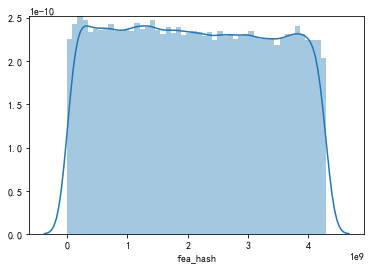

In [100]:
sns.distplot(a.fea_hash);

In [103]:
a.fea_hash.min(),a.fea_hash.max(),a.fea_hash.mean()

(22826, 4294927914, 2119359308.2968993)

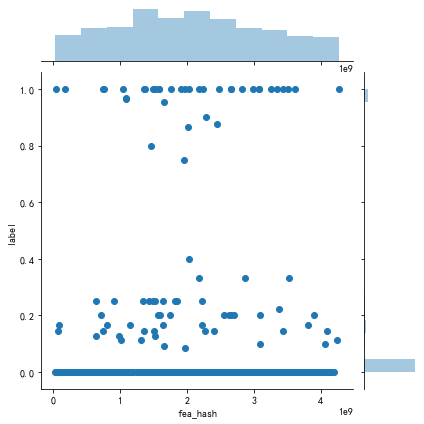

In [118]:
temp=df_train.groupby("android_id").agg({"timestamp":"count","package":"mean","label":"mean","fea_hash":"mean"})
sns.jointplot(x="fea_hash",y="label",data=temp[(temp.timestamp>3)&(temp.timestamp<50)],kind="scatter");

In [6]:
df_train

android_id apptype carrier  dev_height  dev_ppi  dev_width  label  \
sid                                                                         
1438873     316361    1199   46000         0.0      0.0        0.0      1   
1185582     135939     893       0         0.0      0.0        0.0      1   
1555716     399254     821       0       760.0      0.0      360.0      1   
1093419      68983    1004   46000      2214.0      0.0     1080.0      0   
1400089     288999    1076   46000      2280.0      0.0     1080.0      1   
...            ...     ...     ...         ...      ...        ...    ...   
1546078     392477    1028   46000      1920.0      3.0     1080.0      1   
1480612     346134    1001       0      1424.0      0.0      720.0      0   
1698442     499635     761   46000      1280.0      0.0      720.0      0   
1331155     239786     917   46001       960.0      0.0      540.0      0   
1373973     270531     929   46000      2040.0      3.0     1080.0      1   

           lan media_id ntt       os    osv package     timestamp version  \
sid                                                                         
1438873    NaN      104   6  android      9      18  1.559893e+12       8   
1185582    NaN       19   6  android    8.1       0  1.559994e+12       4   
1555716    NaN      559   0  android  8.1.0       0  1.559837e+12       0   
1093419    NaN      129   2  android  8.1.0       0  1.560042e+12       0   
1400089  zh-CN       64   2  android  8.0.0       0  1.559867e+12       5   
...        ...      ...  ..      ...    ...     ...           ...     ...   
1546078  zh-CN      144   6  Android  7.1.2      25  1.559834e+12       7   
1480612    NaN       29   2  android  8.1.0       0  1.559814e+12       3   
1698442    NaN       54   6  android  6.0.1       9  1.559676e+12       0   
1331155  zh_CN      109   2  android  5.1.1       0  1.559840e+12       0   
1373973  zh-CN       59   2  Android  8.1.0      78  1.559922e+12       5   

           fea_hash location   fea1_hash cus_type  
sid                                                
1438873  2135019403        0  2329670524      601  
1185582  2782306428        1  2864801071     1000  
1555716  1392806005        2   628911675      696  
1093419  3562553457        3  1283809327      753  
1400089  2364522023        4  1510695983      582  
...             ...      ...         ...      ...  
1546078   861755946       79   140647032      373  
1480612  1714444511       23  2745131047      525  
1698442  3843262581       25  1326115882      810  
1331155  1984296118      225  1446741112      772  
1373973  1697301943       49  1915763579     1076  

[500000 rows x 19 columns]

### 数据透析

In [13]:
pd.pivot_table(index="carrier",columns="label",aggfunc="count",data=df_train[["android_id","label","carrier"]])

android_id        
label             0       1
carrier                    
-1.0          10435   13820
 0.0          29750   10902
 46000.0     184293  175116
 46001.0      19126   24264
 46003.0      14156   18138

In [35]:
pd.pivot_table(index="dev_height",columns="label",aggfunc="count",data=df_train[["android_id","label","dev_height"]])

android_id         
label               0        1
dev_height                    
0.0           77284.0  29730.0
7.0               NaN      4.0
8.0               NaN      4.0
9.0               NaN      6.0
10.0              NaN      7.0
...               ...      ...
8488.0            NaN      1.0
8528.0            NaN      1.0
8544.0            NaN      2.0
8738.0            NaN      1.0
9024.0            NaN      1.0

[798 rows x 2 columns]

In [37]:
pd.pivot_table(index="dev_ppi",columns="label",aggfunc="count",data=df_train[["android_id","label","dev_ppi"]])

android_id          
label            0         1
dev_ppi                     
0.0       197844.0  185447.0
1.0          126.0      47.0
2.0         6867.0    6024.0
3.0        14056.0    9487.0
4.0           57.0      60.0
...            ...       ...
600.0          1.0       NaN
612.0          1.0       NaN
640.0       1336.0    1278.0
666.0          1.0       NaN
720.0          1.0       NaN

[92 rows x 2 columns]

In [38]:
pd.pivot_table(index="lan",columns="label",aggfunc="count",data=df_train[["android_id","label","lan"]])

android_id          
label                0         1
lan                             
CN               149.0      19.0
TW                 2.0       NaN
ZH                55.0     130.0
Zh-CN            810.0    7312.0
cn             11356.0    9329.0
en                19.0      70.0
en-GB              2.0       NaN
en-US              2.0       1.0
it                 NaN       2.0
ja                 NaN       2.0
ko                 NaN      11.0
mi                 1.0       NaN
tw                67.0      52.0
zh             10621.0   19953.0
zh-CN          90937.0  153537.0
zh-HK              3.0       NaN
zh-MO              NaN       1.0
zh-TW              5.0       2.0
zh-cn            157.0     485.0
zh_CN           4939.0    6663.0
zh_CN_#Hans       16.0      10.0